# Prerequisites
Before you can execute this notebook you'll need the graph logs which you can generate by running the `nervenet_graph_generation.py` in the `NerveNet` subfolder

In [52]:
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_sparse
import networkx as nx

In [53]:

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "tum-adlr-ws21-04":
    os.chdir(basepath.parent.parent)
    
basepath = Path(os.getcwd())

In [54]:
graph_logs_dir = basepath / "logs_parser"
graph_logs_dir.exists(), graph_logs_dir

(True, WindowsPath('c:/Users/tsbau/git/tum-adlr-ws21-04/logs_parser'))

In [55]:
log_files = [x.name for x in graph_logs_dir.glob('*.json') if x.is_file()]
#log_files

In [56]:
#some settings
edge_colors = {
    10:"blue", # root-body
    3:"green", # body-body
    6:"blue", # joint-body
}

def visualize_task_graph(task_name:str, figsize=(10, 10)):
    with open(str(graph_logs_dir / f"{task_name}.json")) as json_file:
        task_log = json.load(json_file)
        
    
    node_colors = {
        "red": task_log["node_type_dict"]["root"],
        "blue": task_log["node_type_dict"]["joint"],
        "black": task_log["node_type_dict"]["body"],
    }

    node_names = {node["id"]: node["raw_name"] for node in task_log["tree"] if "raw_name" in node.keys()}
    node_names[0] = "root"
    
    # Generate graph structure
    G = nx.Graph()

    for i in range(task_log["num_nodes"]):
        G.add_node(i)
        for j in range(i, task_log["num_nodes"]):
            if task_log["relation_matrix"][i][j] != 0:
                G.add_edge(i, j)
                
    # plot the graph
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)#, pos={0: np.array([ 0, 0])})

    options = {"node_size": 100, "alpha": 0.8}
    for color, nodes in node_colors.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)


    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    for p in pos:  # raise text positions
        pos[p][1] += 0.055
    nx.draw_networkx_labels(G, pos, node_names, font_size=12)

    #plt.axis("off")
    plt.show()
    
    return task_log

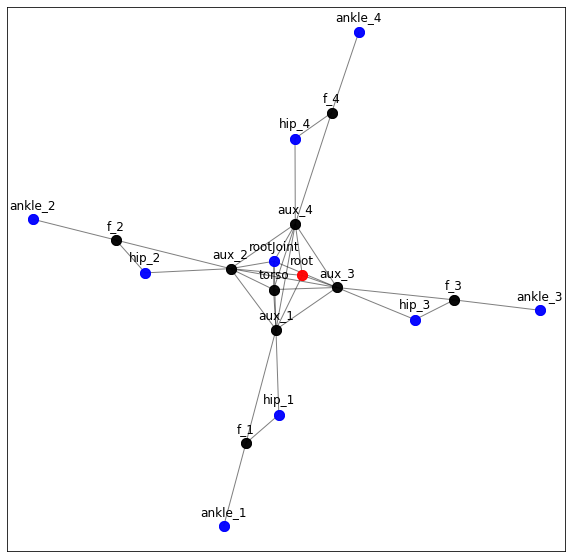

In [57]:
ant_log = visualize_task_graph("AntS-v1")

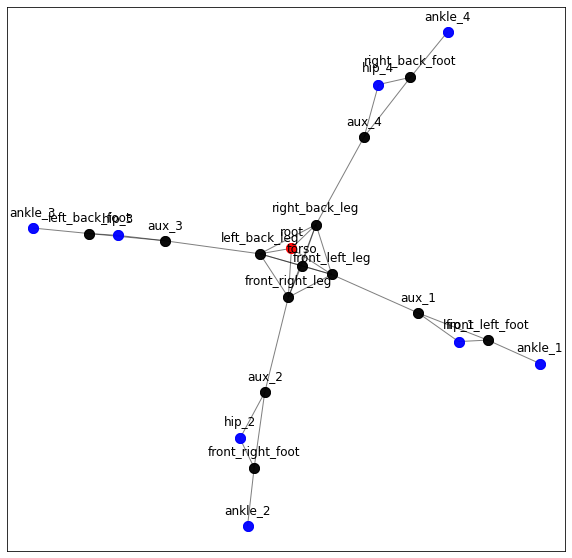

In [58]:
ant_bullet_log = visualize_task_graph("AntBulletEnv-v0")

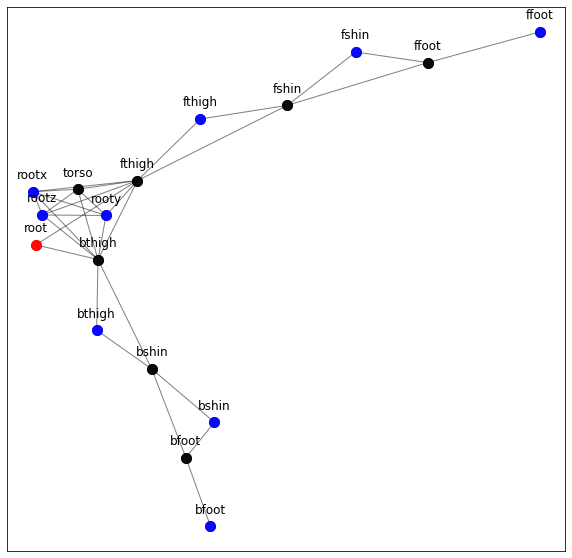

In [59]:
HalfCheetah_log = visualize_task_graph("HalfCheetah-v1")

In [60]:
CentipedeFour_log = visualize_task_graph("CentipedeTwenty-v1", figsize=(60,60))

MemoryError: In RendererAgg: Out of memory

In [ ]:
Humanoid_log = visualize_task_graph("Humanoid-v1")

In [ ]:
WalkersKangaroo_log = visualize_task_graph("WalkersKangaroo-v1")

In [ ]:
WalkersOstrich_log = visualize_task_graph("WalkersOstrich-v1")

In [71]:
ant_bullet_log.keys()

dict_keys(['tree', 'relation_matrix', 'node_type_dict', 'output_type_dict', 'output_list', 'obs_input_mapping', 'static_input_mapping', 'input_type_dict', 'num_nodes'])

In [72]:
relation_matrix = ant_bullet_log["relation_matrix"]
edge_matrix = torch.tensor(
        relation_matrix).to_sparse()
edge_indices = edge_matrix._indices()
edge_attr = edge_matrix.values()[:, None]

In [73]:
edge_indices.shape, edge_attr.shape

(torch.Size([2, 68]), torch.Size([68, 1]))

In [74]:
edge_attr

tensor([[ 10],
        [ 10],
        [ 10],
        [ 10],
        [  3],
        [  3],
        [  3],
        [  3],
        [-10],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [ -6],
        [  3],
        [  6],
        [  6],
        [  3],
        [ -6],
        [ -6],
        [  6],
        [-10],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [ -6],
        [  3],
        [  6],
        [  6],
        [  3],
        [ -6],
        [ -6],
        [  6],
        [-10],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [ -6],
        [  3],
        [  6],
        [  6],
        [  3],
        [ -6],
        [ -6],
        [  6],
        [-10],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [  3],
        [ -6],
        [  3],
        [  6],
        [  6],
        [  3],
        [ -6],
        [ 

In [75]:
edge_matrix.values().abs()

tensor([10, 10, 10, 10,  3,  3,  3,  3, 10,  3,  3,  3,  3,  3,  3,  6,  3,  6,
         6,  3,  6,  6,  6, 10,  3,  3,  3,  3,  3,  3,  6,  3,  6,  6,  3,  6,
         6,  6, 10,  3,  3,  3,  3,  3,  3,  6,  3,  6,  6,  3,  6,  6,  6, 10,
         3,  3,  3,  3,  3,  3,  6,  3,  6,  6,  3,  6,  6,  6])

In [76]:
torch.nn.functional.one_hot(edge_matrix.values()+10).shape

torch.Size([68, 21])

In [ ]:
ant_log["num_nodes"]

In [13]:
ant_log["node_type_dict"]

{'root': [0],
 'joint': [3, 5, 7, 9, 11, 13, 15, 17],
 'body': [1, 2, 4, 6, 8, 10, 12, 14, 16]}

In [73]:
ant_log["relation_matrix"]

[[0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0],
 [0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0],
 [-10, 3, 0, -6, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0],
 [0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 3, -6, 0, -6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [-10, 3, 3, 0, 0, 0, 0, -6, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 3, -6, 0, -6, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [-10, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, -6, 3, 0, 3, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, -6, 0, -6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
 [-10, 3, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, -6, 3, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, -6, 0, -6],
 [0, 0,

dict_keys(['tree', 'relation_matrix', 'node_type_dict', 'output_type_dict', 'output_list', 'obs_input_mapping', 'static_input_mapping', 'input_type_dict', 'debug_info', 'node_parameters', 'para_size_dict', 'num_nodes'])

In [75]:
ant_bullet_log["output_type_dict"]

{'hip': [19, 4, 9, 14], 'ankle': [21, 6, 11, 16]}

In [76]:
ant_bullet_log["output_list"]

[19, 21, 4, 6, 9, 11, 14, 16]

In [78]:
ant_bullet_log["static_input_mapping"]

{'4': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '0 0 1',
  'pos': '0.0 0.0 0.0',
  'range': '-40 40'},
 '6': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '-1 1 0',
  'pos': '0.0 0.0 0.0',
  'range': '30 100'},
 '9': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '0 0 1',
  'pos': '0.0 0.0 0.0',
  'range': '-40 40'},
 '11': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '1 1 0',
  'pos': '0.0 0.0 0.0',
  'range': '-100 -30'},
 '14': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '0 0 1',
  'pos': '0.0 0.0 0.0',
  'range': '-40 40'},
 '16': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '-1 1 0',
  'pos': '0.0 0.0 0.0',
  'range': '-100 -30'},
 '19': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '0 0 1',
  'pos': '0.0 0.0 0.0',
  'range': '-40 40'},
 '21': {'armature': '1',
  'damping': '1',
  'limited': 'true',
  'axis': '1 1 0',
  'pos': '0

In [79]:
ant_bullet_log["input_type_dict"]

{'root': [0],
 'aux': [3, 8, 13, 18],
 'torso': [1],
 'leg': [2, 7, 12, 17],
 'foot': [5, 10, 15, 20],
 'hip': [4, 9, 14, 19],
 'ankle': [6, 11, 16, 21]}

In [80]:
[node for node in ant_bullet_log["tree"] if node["id"] in ant_bullet_log["output_list"]]

[{'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'hip_1',
  'name': 'joint_hip_1',
  'id': 4,
  'parent': 3,
  'info': {'axis': '0 0 1',
   'name': 'hip_1',
   'pos': '0.0 0.0 0.0',
   'range': '-40 40',
   'type': 'hinge'}},
 {'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'ankle_1',
  'name': 'joint_ankle_1',
  'id': 6,
  'parent': 5,
  'info': {'axis': '-1 1 0',
   'name': 'ankle_1',
   'pos': '0.0 0.0 0.0',
   'range': '30 100',
   'type': 'hinge'}},
 {'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'hip_2',
  'name': 'joint_hip_2',
  'id': 9,
  'parent': 8,
  'info': {'axis': '0 0 1',
   'name': 'hip_2',
   'pos': '0.0 0.0 0.0',
   'range': '-40 40',
   'type': 'hinge'}},
 {'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'ankle_2',
  'name': 'joint_ankle_2',
  'id': 11,
  'parent': 10,
  'info': {'axis': '1 1 0',
   'name': 'ankle_2',
   'pos': '0.0 0.0 0.0',
   'r

In [ ]:
dict(enumerate([node for node in ant_bullet_log["tree"] if node["type"] == "joint"]))